In [1]:
# Begin DEV #

In [2]:
# Implementing BERT with Keras
# https://www.kaggle.com/xhlulu/disaster-nlp-keras-bert-using-tfhub/notebook

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
def load_cleaned_submissions():
    data = pd.read_pickle("./data/cleaned_submissions.pkl")
    data = data.loc[data["sentiment"] != "", ["text", "sentiment"]] # Only get labeled instances
    return data

def split_train_test(X, y):
    # Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
    return X_train, X_test, y_train, y_test

In [3]:
data = load_cleaned_submissions()
# data = data[:2000] # To save some memory

In [4]:
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [5]:
from tensorflow.keras import layers
import tensorflow as tf 
import tensorflow_hub as hub
from transformers import BertTokenizer, TFBertModel, BertConfig
import numpy as np

# module_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'
# bert_layer = hub.KerasLayer(module_url, trainable=True)

In [6]:
import numpy as np
import pandas as pd
import tensorflow as tf
tf.gfile = tf.io.gfile # We need to write this, because it changed in tf2 from tf1. 
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub
import tokenization
import numpy as np

In [7]:
%%time
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)

INFO:absl:Using C:\Users\stefa\AppData\Local\Temp\tfhub_modules to cache modules.


Wall time: 12.1 s


In [8]:
from bert import tokenization

vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [9]:
def concatenate_words_in_sentence(text):
    new_text = []
    s = ""
    for sentence in text:
        for word in sentence:
            s = s + word + " "
        new_text.append(s)
        s = ""
    return new_text

In [10]:
x_train = concatenate_words_in_sentence(data["text"].tolist())

In [11]:
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [12]:
def build_model(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(clf_output)
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [31]:
from sklearn.preprocessing import LabelEncoder
lenc = LabelEncoder()
y_train = lenc.fit_transform(data["sentiment"].tolist())

In [32]:
x_for_input, test_input, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=10)

In [37]:
train_input = bert_encode(x_for_input, tokenizer, max_len=100)

In [38]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [40]:
model = build_model(bert_layer, max_len=100)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 100)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 100)]        0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 100)]        0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 1024),       335141889   ['input_word_ids[0][0]',         
                                 (None, 100, 1024)]               'input_mask[0][0]',       

c:\DEV\Master Thesis\App\.thesis\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [41]:
del data
del x_train

In [42]:
# How to solve out of memory issue: https://stackoverflow.com/questions/59617755/training-a-bert-based-model-causes-an-outofmemory-error-how-do-i-fix-this

checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', save_best_only=True)

train_history = model.fit(
    train_input, y_train,
    validation_split=0.2,
    epochs=3,
    callbacks=[checkpoint],
    batch_size=4
)

Epoch 1/3
2873/2873 [==============================] - 798s 268ms/step - loss: -3.3651 - accuracy: 0.5184 - val_loss: -3.4084 - val_accuracy: 0.5301
Epoch 2/3
2873/2873 [==============================] - 740s 258ms/step - loss: -4.0670 - accuracy: 0.5189 - val_loss: -3.9636 - val_accuracy: 0.5301
Epoch 3/3
2873/2873 [==============================] - 737s 257ms/step - loss: -4.6989 - accuracy: 0.5189 - val_loss: -4.5521 - val_accuracy: 0.5301


In [44]:
model.load_weights('model.h5')
test_pred = model.predict(bert_encode(test_input, tokenizer, max_len=100))

In [46]:
from sklearn.metrics import classification_report
print(classification_report(y_test, test_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       723
           1       0.52      1.00      0.69      1871
           2       0.00      0.00      0.00       997

    accuracy                           0.52      3591
   macro avg       0.17      0.33      0.23      3591
weighted avg       0.27      0.52      0.36      3591



c:\DEV\Master Thesis\App\.thesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\DEV\Master Thesis\App\.thesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\DEV\Master Thesis\App\.thesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


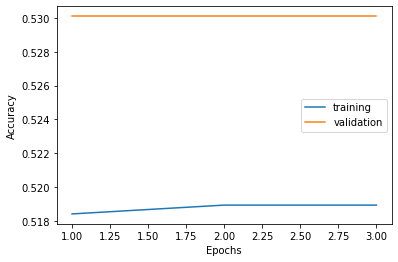

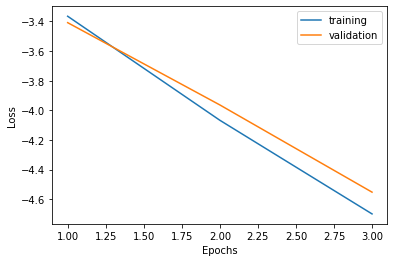

In [53]:
import matplotlib.pyplot as plt

acc_history = train_history.history["accuracy"]
val_acc_history = train_history.history["val_accuracy"]

plt.plot(range(1, len(acc_history) + 1), acc_history)
plt.plot(range(1, len(val_acc_history) + 1), val_acc_history)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["training", "validation"])
plt.show()

loss_history = train_history.history["loss"]
val_loss_history = train_history.history["val_loss"]

plt.plot(range(1, len(loss_history) + 1), loss_history)
plt.plot(range(1, len(val_loss_history) + 1), val_loss_history)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["training", "validation"])
plt.show()

In [ ]:
# End DEV #

In [1]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import pandas as pd

data = pd.read_pickle("./data/cleaned_submissions.pkl")
data = data.loc[data["sentiment"] != "", ["text", "sentiment"]] # Only get labeled instances

# Encode labels
lenc = LabelEncoder()
y = lenc.fit_transform(data["sentiment"])

# Vectorize text using tfidf
tfidf = TfidfVectorizer(preprocessor=' '.join, lowercase=False, min_df=5) # min_df = Minimum occurance of words
X = tfidf.fit_transform(data["text"])

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [3]:
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")
model.summary()

2021-11-22 17:14:53.065611: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


In [4]:
# Data

# DEV!!!
# Less data, so I can check if the model works
X_train_bert = X_train[:50] # X_train.toarray()[:50, :, None] -> from lstm
y_train_bert = y_train[:50]

In [29]:
import numpy as np
from tensorflow.sparse import reorder
import tensorflow as tf

def convert_sparse_matrix_to_sparse_tensor(X):
    coo = X.tocoo()
    indices = np.mat([coo.row, coo.col]).transpose()
    return tf.SparseTensor(indices, values = coo.data, dense_shape = coo.shape)

In [54]:
def convert_sparse_matrix_to_dictionary(X):
    dic = {}
    coo = X.tocoo()
    for i in range(0, coo.row):
        dic[i] = item.col
    print(dic)

In [31]:
coo = X_train_bert.tocoo()
indices = np.mat([coo.row, coo.col]).transpose()
print(tf.SparseTensor(indices, coo.data, coo.shape))

SparseTensor(indices=tf.Tensor(
[[   0 3057]
 [   0 2642]
 [   0 3787]
 ...
 [  48 2746]
 [  48 2137]
 [  49 2137]], shape=(669, 2), dtype=int64), values=tf.Tensor(
[0.59542567 0.60564568 0.51284646 0.1251003  0.62899846 0.74640758
 0.21733997 0.15881666 0.15065584 0.14706971 0.12751685 0.14938152
 0.12992945 0.14706971 0.16099216 0.16099216 0.12868378 0.11051738
 0.12347085 0.12950483 0.10531676 0.12173798 0.10163091 0.13373161
 0.52506096 0.14818947 0.09749081 0.10389945 0.08722882 0.09184639
 0.31873883 0.08660123 0.09368347 0.06484686 0.11916851 0.07623556
 0.09338411 0.22905329 0.09690672 0.09801749 0.04434515 0.08364269
 0.07285628 0.10389945 0.08684972 0.10210092 0.07692903 0.09493194
 0.07525298 0.11471555 0.07061359 0.11990253 0.06940748 0.07790467
 0.08529129 0.06971818 0.0898785  0.05564887 0.48529515 0.41759496
 0.36845519 0.29808807 0.37597191 0.40961901 0.22544147 0.07430258
 0.65422268 0.48853088 0.56989251 0.09248129 0.41630068 0.37163055
 0.81454622 0.15842644 0.396248

In [32]:
X_train_berti = reorder(convert_sparse_matrix_to_sparse_tensor(X_train_bert))

In [38]:
type(X_train_berti)

tensorflow.python.framework.sparse_tensor.SparseTensor

In [37]:
tf.sparse.to_dense(X_train_berti, validate_indices = False)

<tf.Tensor: shape=(50, 4936), dtype=float64, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])>

In [35]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])

model.fit(X_train_berti, y_train_bert,  epochs = 2)

Epoch 1/2


ValueError: in user code:

    File "/Users/stefanwinter/Local/Thesis/App/.thesis/lib/python3.9/site-packages/keras/engine/training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "/Users/stefanwinter/Local/Thesis/App/.thesis/lib/python3.9/site-packages/keras/engine/training.py", line 867, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/stefanwinter/Local/Thesis/App/.thesis/lib/python3.9/site-packages/keras/engine/training.py", line 860, in run_step  **
        outputs = model.train_step(data)
    File "/Users/stefanwinter/Local/Thesis/App/.thesis/lib/python3.9/site-packages/transformers/modeling_tf_utils.py", line 796, in train_step
        y_pred = self(x, training=True)
    File "/Users/stefanwinter/Local/Thesis/App/.thesis/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None

    ValueError: Exception encountered when calling layer "tf_bert_for_sequence_classification" (type TFBertForSequenceClassification).
    
    in user code:
    
        File "/Users/stefanwinter/Local/Thesis/App/.thesis/lib/python3.9/site-packages/transformers/models/bert/modeling_tf_bert.py", line 1733, in call  *
            inputs = input_processing(
        File "/Users/stefanwinter/Local/Thesis/App/.thesis/lib/python3.9/site-packages/transformers/modeling_tf_utils.py", line 447, in input_processing  *
            raise ValueError(
    
        ValueError: Data of type <class 'tensorflow.python.framework.sparse_tensor.SparseTensor'> is not allowed only (<class 'tensorflow.python.framework.ops.Tensor'>, <class 'bool'>, <class 'int'>, <class 'transformers.file_utils.ModelOutput'>, <class 'tuple'>, <class 'list'>, <class 'dict'>, <class 'numpy.ndarray'>, <class 'tensorflow.python.keras.engine.keras_tensor.KerasTensor'>) is accepted for input_ids.
    
    
    Call arguments received:
      • input_ids=<tensorflow.python.framework.sparse_tensor.SparseTensor object at 0x7fdb4741eac0>
      • attention_mask=None
      • token_type_ids=None
      • position_ids=None
      • head_mask=None
      • inputs_embeds=None
      • output_attentions=None
      • output_hidden_states=None
      • return_dict=None
      • labels=None
      • training=True
      • kwargs=<class 'inspect._empty'>


# Start from the section below, it works
Copy it to sentiment_models.ipynb once the LSTM is done training. Then delete this notebook.

In [30]:
# Implementing BERT from scratch

In [1]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import pandas as pd

data = pd.read_pickle("./data/cleaned_submissions.pkl")
data = data.loc[data["sentiment"] != "", ["text", "sentiment"]] # Only get labeled instances

In [2]:
len(data)

17955

In [3]:
data = data[:100]

In [4]:
X = data.text
y = data.sentiment

In [5]:
new_X = []
for i, sentence in enumerate(X):
    s = ""
    for word in sentence:
        s = s + " " + word
        
    new_X.append(s)

In [6]:
new_new_X = []
for item in new_X:
    new_new_X.append(item[:100]) # Will probably have to fix that for the final submission

In [7]:
new_X = new_new_X

In [8]:
X = new_X # new_X will be needed later, don't delete

In [9]:
# Encode labels
lenc = LabelEncoder()
y = lenc.fit_transform(y)

In [10]:
# Train-Val Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=10)

In [11]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=10)

In [12]:
import re
def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [13]:
print('Original: ', X[0])
print('Processed: ', text_preprocessing(X[0]))

Original:   gamestop short squeeze discussion short interest insane high number share also gamestop short term 
Processed:  gamestop short squeeze discussion short interest insane high number share also gamestop short term


In [14]:
from transformers import BertTokenizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad, taken from cell below!
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [15]:
# Concatenate train data and test data
# all_tweets = np.concatenate([data.tweet.values, test_data.tweet.values])

# Encode our concatenated data
encoded_discussions = [tokenizer.encode(sent, add_special_tokens=True) for sent in new_X]

# Find the maximum length
max_len = max([len(sent) for sent in encoded_discussions])
print('Max length: ', max_len)

## This is important!!!!!!!! ##
print("With this problem, BERT does not work! That is one of the limitations!!! For now, I will just strip my sentences at 512. But I will need to think of a solution!!!")
## This is important!!!!!!!! ##

Max length:  35
With this problem, BERT does not work! That is one of the limitations!!! For now, I will just strip my sentences at 512. But I will need to think of a solution!!!


In [16]:
import torch

# Specify `MAX_LEN`
MAX_LEN = max_len

# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_for_bert([X[0]])[0].squeeze().numpy())
# print('Original: ', X[0])
# print('Token IDs: ', token_ids)

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Tokenizing data...


c:\DEV\Master Thesis\App\.thesis\lib\site-packages\transformers\tokenization_utils_base.py:2212: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [17]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 32

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [18]:
%%time
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 3

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

Wall time: 17 ms


In [19]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=2):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

In [20]:
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [21]:
import torch
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("There is a GPU available!")
else:
    device = torch.device("cpu")
    print("CPU only")

There is a GPU available!


In [22]:
import numpy as np
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(bert_classifier, train_dataloader, val_dataloader, epochs=2, evaluation=True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------


RuntimeError: "nll_loss_forward_reduce_cuda_kernel_2d_index" not implemented for 'Int'

In [23]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [24]:
# Concatenate the train set and the validation set
full_train_data = torch.utils.data.ConcatDataset([train_data, val_data])
full_train_sampler = RandomSampler(full_train_data)
full_train_dataloader = DataLoader(full_train_data, sampler=full_train_sampler, batch_size=32)

# Train the Bert Classifier on the entire training data
set_seed(42)
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(bert_classifier, full_train_dataloader, epochs=2)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------


RuntimeError: "nll_loss_forward_reduce_cuda_kernel_2d_index" not implemented for 'Int'